# <center>Birds Species Classification</center>

In [21]:
!pip install tensorflow

### 1. Load and Preprocess the Datasets

In [22]:
import os
import glob

# Define the path to the folder containing the images
IMAGE_FOLDER = "Datasets"
IMAGE_FOLDER_TRAIN = "Datasets/train"
IMAGE_FOLDER_TEST = "Datasets/test"
# Get the paths to all the image files in the folder
image_paths = glob.glob(os.path.join(IMAGE_FOLDER, "*/*.jpg"))

# Create a list of tuples containing the file path and label
data = [(path, os.path.basename(os.path.dirname(path))) for path in image_paths]

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create an ImageDataGenerator for preprocessing the images
data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
)

# Load the training set
train_generator = data_generator.flow_from_directory(
    directory=IMAGE_FOLDER_TRAIN,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

# Load the validation set
val_generator = data_generator.flow_from_directory(
    directory=IMAGE_FOLDER_TEST,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 3270 images belonging to 25 classes.
Found 25 images belonging to 25 classes.


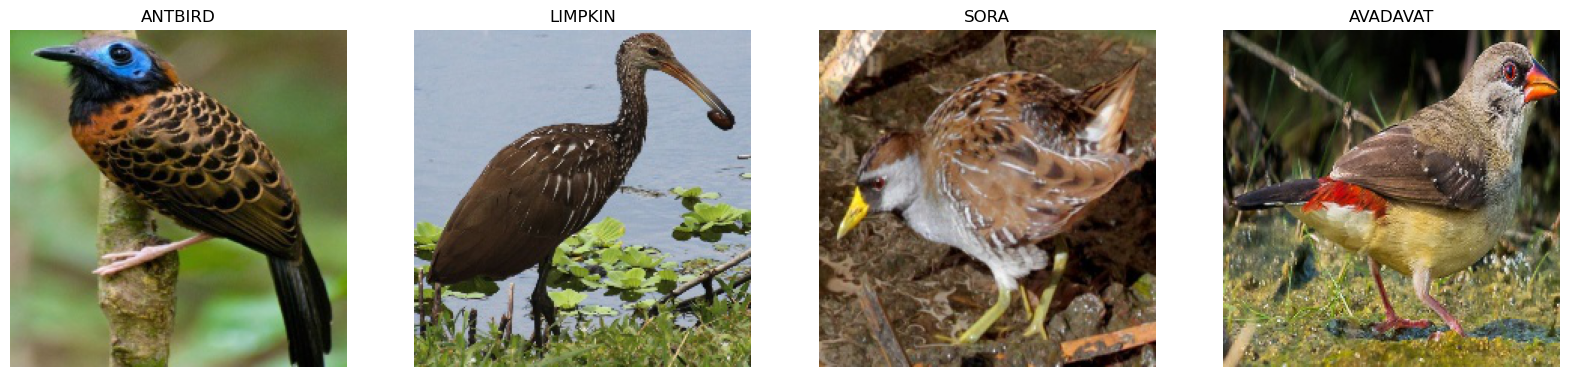

In [24]:
# display some Images used for training the model
from PIL import Image
import matplotlib.pyplot as plt

images = [
    "Datasets/test/ANTBIRD/1.jpg",
    "Datasets/train/LIMPKIN/001.jpg",
    "Datasets/train/SORA/013.jpg",
    "Datasets/train/AVADAVAT/015.jpg"
]

def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 10))
    for i, image_path in enumerate(images):
        # Define the path to the image
        image_path = image_path

        # Load the image
        img = Image.open(image_path)

        # Display the image
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(image_path.split("/")[2])
    plt.show()

# call the function
plot_images(images)

In [25]:
# display the labels
for target_name, label in train_generator.class_indices.items():
    print(f"{target_name} --> {label}")

ABBOTTS BOOBY --> 0
ANDEAN SISKIN --> 1
ANHINGA --> 2
ANIANIAU --> 3
ANNAS HUMMINGBIRD --> 4
ANTBIRD --> 5
ANTILLEAN EUPHONIA --> 6
APAPANE --> 7
APOSTLEBIRD --> 8
ARARIPE MANAKIN --> 9
ASHY STORM PETREL --> 10
ASHY THRUSHBIRD --> 11
ASIAN CRESTED IBIS --> 12
ASIAN DOLLARD BIRD --> 13
ASIAN GREEN BEE EATER --> 14
AUCKLAND SHAQ --> 15
AUSTRAL CANASTERO --> 16
AUSTRALASIAN FIGBIRD --> 17
AVADAVAT --> 18
AZARAS SPINETAIL --> 19
AZURE BREASTED PITTA --> 20
AZURE JAY --> 21
AZURE TANAGER --> 22
LIMPKIN --> 23
SORA --> 24


### 2. Build the Base Model

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model without the top (classification) layer
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=train_generator.image_shape
)

# Add a new top (classification) layer for our bird species classification task
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(len(train_generator.class_indices), activation="softmax")(x)

# Create a new model that combines the VGG16 base model with our new top layer
model = Model(inputs=base_model.input, outputs=x)

# Freeze the weights of the VGG16 base model so that we only train the new top layer
for layer in base_model.layers:
    layer.trainable = False

### Compile the Model

In [27]:
from tensorflow.keras.optimizers import Adam

# compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate=0.0001),
    metrics = ["accuracy"]
)

In [28]:
# display the model architecture
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Train the model

In [29]:
batch_size = 4

history = model.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator,
)

Epoch 1/5
103/103 [==============================] - 376s 4s/step - loss: 2.4303 - accuracy: 0.3187 - val_loss: 1.2788 - val_accuracy: 0.7200
Epoch 2/5
103/103 [==============================] - 377s 4s/step - loss: 1.2929 - accuracy: 0.6324 - val_loss: 0.6743 - val_accuracy: 0.8400
Epoch 3/5
103/103 [==============================] - 374s 4s/step - loss: 0.8808 - accuracy: 0.7538 - val_loss: 0.4846 - val_accuracy: 0.9200
Epoch 4/5
103/103 [==============================] - 421s 4s/step - loss: 0.6930 - accuracy: 0.8110 - val_loss: 0.4690 - val_accuracy: 0.9200
Epoch 5/5
103/103 [==============================] - 415s 4s/step - loss: 0.5299 - accuracy: 0.8581 - val_loss: 0.3994 - val_accuracy: 0.9200


### Evaluate the model

In [30]:
train_loss, train_acc = model.evaluate(train_generator)

print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")

103/103 [==============================] - 361s 4s/step - loss: 0.2665 - accuracy: 0.9550
Train Loss: 0.2664988934993744
Train Accuracy: 0.9550458788871765


In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    IMAGE_FOLDER_TEST,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 125 images belonging to 25 classes.


In [32]:
test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

32/32 [==============================] - 15s 454ms/step - loss: 0.3431 - accuracy: 0.9040
Test Loss: 0.3430744707584381
Test Accuracy: 0.9039999842643738


### Save the trained model

In [34]:
model.save("bird_vgg.h5")

### Import the saved model

In [35]:
from keras.models import load_model

# load the model
loaded_model = load_model("bird_vgg.h5")

# display the it's architecture
loaded_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Make a Prediction using the Model

1/1 [==============================] - 0s 263ms/step


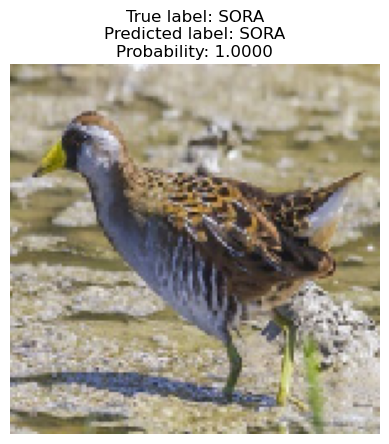

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("bird_vgg.h5")

# Define the path to the test images
test_dir = 'Datasets/test'

# Define the dictionary to map the class indices to their respective class names
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Function to preprocess the image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Get the list of all images in the test directory
test_images = os.listdir(test_dir)

# Pick a correctly classified image
correct_image_path = os.path.join(test_dir, 'SORA', '1.jpg')

# Preprocess the image
correct_image = preprocess_image(correct_image_path)

# Get the true label of the image
true_label = os.path.basename(os.path.dirname(correct_image_path))

# Get the predicted label of the image
predicted_prob = model.predict(correct_image)[0]
predicted_label = class_names[np.argmax(predicted_prob)]

# Display the image
plt.imshow(load_img(correct_image_path, target_size=(150, 150)))
plt.title(f'True label: {true_label}\nPredicted label: {predicted_label}\nProbability: {predicted_prob[np.argmax(predicted_prob)]:.4f}')
plt.axis('off')
plt.show()


#### <center>... The End! ...</center>